# Исследование решений по увеличению выручки интернет-магазина

Отдел маркетинга крупного интернет-магазина подготовил список гипотез для увеличения выручки.

**Цель исследования**

Приоритизировать гипотезы, запустить A/B-тест и проанализировать результаты.

**Описание данных**

У нас в распоряжении есть файл с 9 гипотезами по увеличению выручки и 2 файла с результатами A/B теста.

Таблица `/datasets/hypothesis.csv`:

    Hypothesis — краткое описание гипотезы;
    Reach — охват пользователей по 10-балльной шкале;
    Impact — влияние на пользователей по 10-балльной шкале;
    Confidence — уверенность в гипотезе по 10-балльной шкале;
    Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение, тем дороже проверка гипотезы.

Таблица `/datasets/orders.csv`:

    transactionId — идентификатор заказа;
    visitorId — идентификатор пользователя, совершившего заказ;
    date — дата, когда был совершён заказ;
    revenue — выручка заказа;
    group — группа A/B-теста, в которую попал заказ.

Таблица `/datasets/visitors.csv`:

    date — дата;
    group — группа A/B-теста;
    visitors — количество пользователей в указанную дату в указанной группе A/B-теста

**Ход исследования:**

1. Обзор данных и подготовка.
2. Приоритизация гипотез.
3. Анализ A/B-теста.
4. Общий вывод.

## Обзор данных и подготовка

### Импорт библиотек

В первую очередь импортируем необходимые для исследования библиотеки.

In [1]:
import numpy as np # импорт библиотеки numpy
import pandas as pd # импорт библиотеки pandas
import matplotlib.pyplot as plt # импорт библиотеки matplotlib
import datetime as dt # импорт библиотеки datetime
import scipy.stats as st # импорт библиотеки scipy

pd.set_option('display.max_colwidth', None) # сброс ограничения на количество символов в записи

### Изучение данных из файла

Сохраним данные о гипотезах и результатах A/B-теста в переменные. Выведем таблицы на экран для ознакомления с содержимым.

In [2]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv') # сохранение
orders = pd.read_csv('/datasets/orders.csv')         # таблиц 
visitors = pd.read_csv('/datasets/visitors.csv')     # в переменные

display(hypothesis, orders.head(5), visitors.head(5)) # вывод на экран

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


Исправим нарушения стиля в названиях столбцов таблиц `hypothesis` и `orders`. Приведем их к нижнему змеиному регистру, проверим результат.

In [3]:
hypothesis.columns = hypothesis.columns.str.lower() # приведение названий столбцов к нижнему регистру
orders = orders.rename(columns={'transactionId': 'transaction_id', 'visitorId': 'visitor_id'}) # переименование столбцов

for df in (hypothesis, orders, visitors): # цикл для вывода на экран информации о таблицах
    df.info()
    print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   transaction_id  1197 non-null   int64 
 1   visitor_id      1197 non-null   int64 
 2   date            1197 non-null   object
 3   revenue         1197 non-null   int64 
 4   group           1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 column

Столбец `date` в таблицах `orders` и `visitors` имеет строковый тип. Переведем данные в ячейках в тип даты и проверим результат.

In [4]:
for df in (orders, visitors): # цикл для приведения строки к формату даты
    df['date'] = df['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
    df.info()
    print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1197 non-null   int64         
 1   visitor_id      1197 non-null   int64         
 2   date            1197 non-null   datetime64[ns]
 3   revenue         1197 non-null   int64         
 4   group           1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB



Сейчас все данные в ячейках соответствуют типам данных в столбцах. Пропусков нет, проверим наличие явных дубликатов в таблицах.

In [5]:
for name, df in zip(['hypothesis', 'orders', 'visitors'], [hypothesis, orders, visitors]):
    print(f'Дубликатов в таблице {name}: {df.duplicated().sum()}') # цикл для проверки таблиц на дубликаты

Дубликатов в таблице hypothesis: 0
Дубликатов в таблице orders: 0
Дубликатов в таблице visitors: 0


### Вывод

Мы привели назавния столбцов к единому стилю, поменяли тип данных в ячейках и проверили таблицы на наличие явных дубликатов.

## Приоритизация гипотез

На этом этапе мы рассчитаем приоритет гипотез методами ICE и RICE, а также сравним результаты.

### Фреймворк ICE

Применим фреймворк ICE для приоритизации гипотез. 

Формула расчета: **ICE = Impact * Confidence / Efforts**

    где:
    
    Impact — сила влияния изменений на пользователей, их опыт и удовлетворенность продуктом
    Confidence — уверенность в определенном влиянии изменений на пользователей
    Efforts — сколько стоит протестировать эту гипотезу

Отсортируем гипотезы по убыванию приоритета.

In [6]:
hypothesis['ice'] = round( # расчет ICE с округлением до двух знаков
    hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts'], 2
) # расчет ICE 
display(hypothesis[['hypothesis', 'ice']].sort_values(by='ice', ascending=False)) # вывод на экран с сортировкой

,hypothesis,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


### Фреймворк RICE

Теперь применим модификацию предыдущего способа, фреймворк RICE с дополнительным параметром Reach (охват пользователей).

Формула расчета: **RICE = Reach * Impact * Confidence / Efforts**

Также отсортируем гипотезы по убыванию приоритета.

In [7]:
hypothesis['rice'] = round( # расчет RICE с округлением до двух знаков
    hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts'], 2
) 
display(hypothesis[['hypothesis', 'rice']].sort_values(by='rice', ascending=False)) # вывод на экран с сортировкой

,hypothesis,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


### Вывод

После применения фреймворка RICE, приоритет гипотез изменился. Самая перспективная гипотеза 8 спустилась с первого места на пятое. Перспективными остались гипотезы 7, 0 и 6, но их порядок изменился, теперь на первом месте гипотеза 7. Это произошло по причине того, что в расчет был добавлен параметр Reach, а у гипотезы 7 он самый высокий - 10, в то время как у гипотезы 8 параметр Reach самый низкий - 1.

## Анализ A/B-теста

На этом этапе мы проанализируем результаты A/B-теста.

### Подготовка к анализу

Перед проведением анализа A/B теста, проверим не попали ли пользователи одновременно в обе группы.

In [8]:
group_a = orders[orders['group'] == 'A']['visitor_id'].unique() # сбор уникальных
group_b = orders[orders['group'] == 'B']['visitor_id'].unique() # пользователей по группам

both = [] # пустой список

for i in group_a: # цикл для проверки
    if i in group_b: # совпадений пользователей
        both.append(i) # добавление в список
        
print(f'Одновременно в обе группы попало {len(both)} пользователей.')

Одновременно в обе группы попало 58 пользователей.


Удалим этих пользователей с помощью среза.

In [9]:
orders = orders.query('visitor_id not in @both') # срез по переменной со списком пользователей

Теперь соберём агрегированные кумулятивные по дням данные о заказах и выведем таблицу на экран.

In [10]:
dates_droups = orders[['date','group']].drop_duplicates() # создаем массив уникальных пар значений дат и групп теста

orders_aggregated = dates_droups.apply( # получаем агрегированные кумулятивные по дням данные о заказах 
    lambda x: orders[np.logical_and(
        orders['date'] <= x['date'], orders['group'] == x['group'])].agg(
        {'date' : 'max', 'group' : 'max', 'transaction_id' : 'nunique',
         'visitor_id' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group']) 

visitors_aggregated = dates_droups.apply( # получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
    lambda x: visitors[np.logical_and(
        visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg(
        {'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(
    by=['date','group']) 

cumulative_data = orders_aggregated.merge( # объединяем кумулятивные данные в одной таблице 
    visitors_aggregated, left_on=['date', 'group'], right_on=['date', 'group'])

cumulative_data.columns = ['date', # присваиваем столбцам понятные названия
                          'group',
                          'orders',
                          'buyers',
                          'revenue',
                          'visitors'] 

display(cumulative_data.head(5))

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845


### Анализ кумулятивных данных

Построим график кумулятивной выручки по группам.

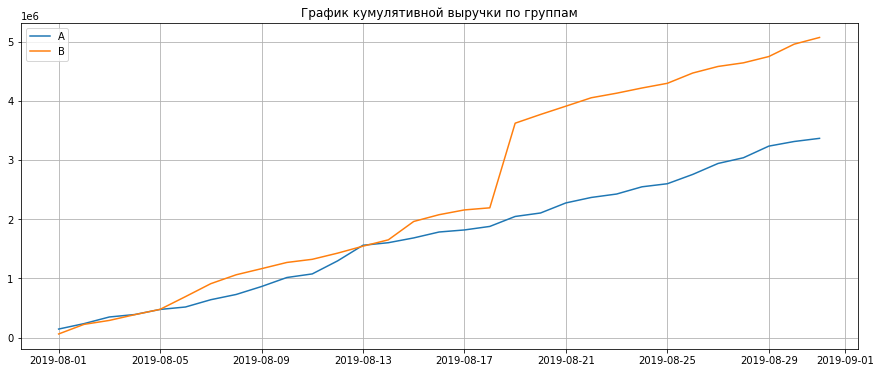

In [11]:
cumulative_revenue_a = cumulative_data[ # датафрейм с кумулятивным количеством заказов и выручкой по дням в группе A
    cumulative_data['group'] == 'A'][['date', 'revenue', 'orders']]

cumulative_revenue_b = cumulative_data[ # датафрейм с кумулятивным количеством заказов и выручкой по дням в группе B
    cumulative_data['group'] == 'B'][['date', 'revenue', 'orders']]

plt.figure(figsize=(15, 6)) # размер фигуры
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue'], label='A') # график выручки группы А
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue'], label='B') # график выручки группы B
plt.title('График кумулятивной выручки по группам') # заговолок графика
plt.legend() # включение легенды
plt.grid() # включение сетки
plt.show()

Выручка увеличивается почти равномерно в течение всего теста, но у группы B после 17.08.2019 наблюдается резкий скачок выручки. Это может означать всплеск числа заказов или появление очень дорогих заказов в выборке. Мы проанализируем это позже.


Построим график кумулятивного среднего чека по группам.

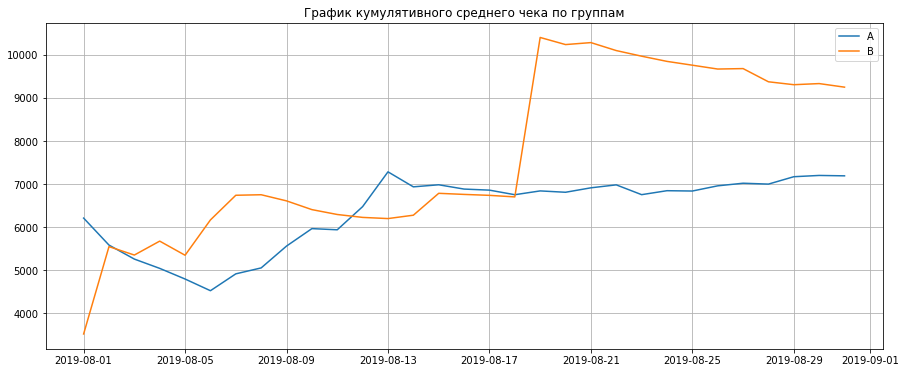

In [12]:
plt.figure(figsize=(15, 6)) # размер фигуры
plt.plot(cumulative_revenue_a['date'], # график среднего чека группы А
         cumulative_revenue_a['revenue'] / cumulative_revenue_a['orders'], label='A')
plt.plot(cumulative_revenue_b['date'], # график среднего чека группы B
         cumulative_revenue_b['revenue'] / cumulative_revenue_b['orders'], label='B')
plt.title('График кумулятивного среднего чека по группам') # заговолок графика
plt.legend() # включение легенды
plt.grid() # включение сетки
plt.show()

Средний чек для группы А становится равномерным ближе к концу теста. У группы B показатель крайне нестабильный, возможно нужно больше данных, чтобы прийти к реальному среднему чеку и установиться на его уровне.

Построим график относительного изменения кумулятивного среднего чека группы B к группе A.

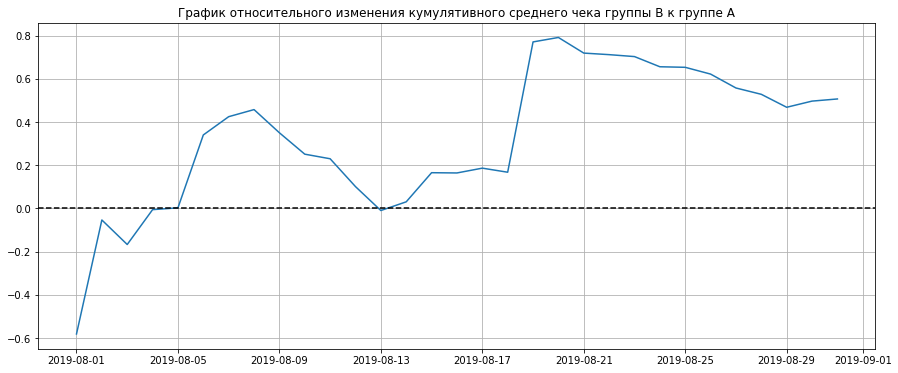

In [13]:
merged_cumulative_revenue = cumulative_revenue_a.merge( # объединение таблиц
    cumulative_revenue_b, left_on='date', right_on='date', how='left', suffixes=['_a', '_b'])

plt.figure(figsize=(15, 6)) # размер фигуры
plt.plot( # cтроим отношение средних чеков
    merged_cumulative_revenue['date'], (
        merged_cumulative_revenue['revenue_b'] / merged_cumulative_revenue['orders_b']) / (
        merged_cumulative_revenue['revenue_a'] / merged_cumulative_revenue['orders_b']) - 1)
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A') # заговолок графика
plt.axhline(y=0, color='black', linestyle='--') # пунктирная линия оси X
plt.grid() # включение сетки
plt.show()

Группа B лучше группы A, но в некоторых точках наблюдаются резкие скачки, но возможно это крупные заказы и выбросы. 

Построим график кумулятивной конверсии по группам.

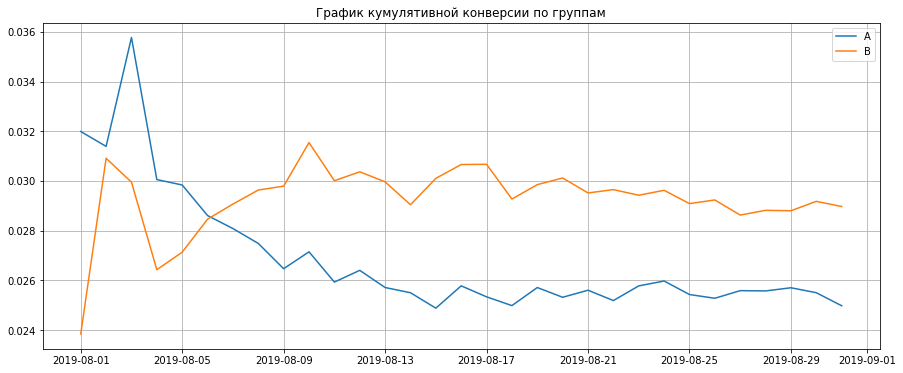

In [14]:
cumulative_data['conversion'] = cumulative_data['orders'] / cumulative_data['visitors'] # считаем кумулятивную конверсию

cumulative_data_a = cumulative_data[cumulative_data['group'] == 'A'] # отделяем данные по группе A
cumulative_data_b = cumulative_data[cumulative_data['group'] == 'B'] # отделяем данные по группе B

plt.figure(figsize=(15, 6))
plt.plot(cumulative_data_a['date'], cumulative_data_a['conversion'], label='A') # строим
plt.plot(cumulative_data_b['date'], cumulative_data_b['conversion'], label='B') # графики
plt.title('График кумулятивной конверсии по группам') # заговолок графика
plt.grid() # включение сетки
plt.legend() # включение легенды
plt.show()

В начале теста наблюдались резкие всплески, но затем конверсия группы A просела и зафиксировалась. Конверсия группы B так же зафиксировалась, но на более высоком значении.

Построим график относительного изменения кумулятивной конверсии группы B к группе A.

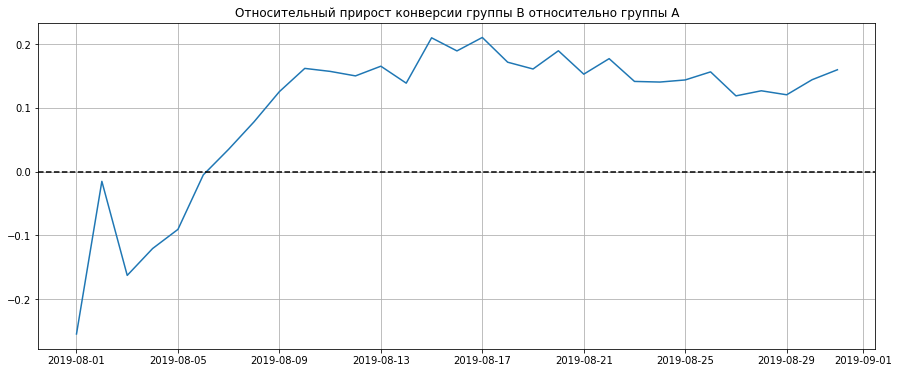

In [15]:
merged_cumulative_conversions = cumulative_data_a[['date','conversion']].merge( # объединение таблиц
    cumulative_data_b[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['_a', '_b'])

plt.figure(figsize=(15, 6)) # размер фигуры
plt.plot( # строим график
    merged_cumulative_conversions['date'],
    merged_cumulative_conversions['conversion_b'] / merged_cumulative_conversions['conversion_a'] - 1)
plt.title('Относительный прирост конверсии группы B относительно группы A') # заговолок графика
plt.axhline(y=0, color='black', linestyle='--') # пунктирная линия оси X
plt.grid() # включение сетки
plt.show()

В начале теста группа B значительно проигрывала группе A, затем вырвалась вперёд и зафиксировалась.

### Анализ выбросов и аномалий

Проанализируем наличие выбросов и аномалий, которые могут искажать результаты A/B-теста.

Нас интересуют очень дорогие заказы и пользователи с нетипично большим количеством заказов. Если дорогой заказ попадёт в одну из групп теста, он сразу исказит результаты и сделает победителем ту группу, в которой оказался. Пользователи, совершившие много заказов, влияют на числитель формулы конверсии. Скорее всего, их поведение отличается от нормального. При этом такие покупки — исключение, которое проявилось не из-за тестирования гипотезы, а случайно. Далее мы будем удалять аномально дорогие заказы и пользователей с большим количеством заказов для проведения расчетов по "очищенным" данным.

Построим точечный график количества заказов по пользователям для определения границы аномального числа заказов.

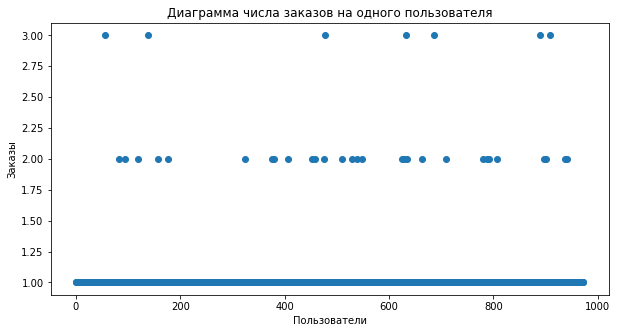

In [16]:
orders_by_users = (orders.groupby('visitor_id', as_index=False).agg({'transaction_id': 'nunique'})) # группировка таблицы
orders_by_users.columns = ['user_id', 'orders'] # переименование столбцов

x_values = pd.Series(range(0, len(orders_by_users))) # задаем ось X

plt.figure(figsize=(10, 5)) # размер фигуры
plt.scatter(x_values, orders_by_users['orders']) # строим график
plt.title('Диаграмма числа заказов на одного пользователя') # заговолок графика
plt.xlabel('Пользователи') # название оси X
plt.ylabel('Заказы') # название оси Y
plt.show()

Большинство пользователей делают 1 заказ, но есть и те, кто делал 2-3 заказа. Их точная доля неизвестна и непонятно, считать ли их аномалиями. 

В статистике принято отсеивать от 1% до 5% наблюдений с крайними значениями. Посчитаем 95-й и 99-й перцентили количества заказов на пользователя.

In [17]:
print(np.percentile(orders_by_users['orders'], [95, 99]))

[1. 2.]


Не более 5% пользователей оформляли больше двух заказов. Выберем границу в 1 заказ для определения аномальных пользователей. 

Построим точечный график стоимостей заказов для определения границы аномальной стоимости заказов.

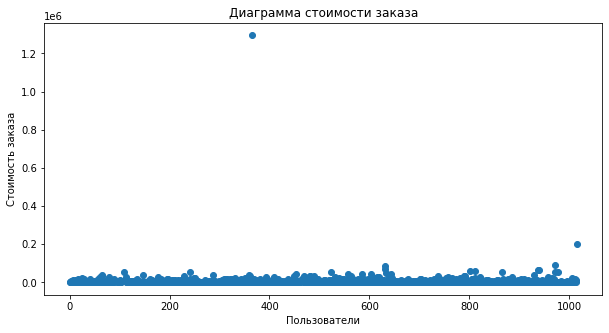

In [18]:
x_values = pd.Series(range(0, len(orders['revenue']))) # задаем ось X

plt.figure(figsize=(10, 5)) # размер фигуры
plt.scatter(x_values, orders['revenue']) # строим график
plt.title('Диаграмма стоимости заказа') # заговолок графика
plt.xlabel('Пользователи') # название оси X
plt.ylabel('Стоимость заказа') # название оси Y
plt.show()

Дорогих немного, но есть один очень дорогой заказ, который мог исказить результаты теста. Посчитаем 95-й и 99-й перцентили стоимости заказов.

In [19]:
print(np.percentile(orders['revenue'], [95, 99]))

[26785. 53904.]


Не более 5% заказов дороже 26785 рублей и не более 1% дороже 53904 рублей. Выберем границу аномальной стоимости заказов в 27000 руб.

### Статистический анализ "сырых" данных

Начнём с подготовки данных.

In [20]:
visitors_a_daily = visitors[visitors['group'] == 'A'][['date', 'visitors']] # количество пользователей в день в группе A
visitors_a_daily.columns = ['date', 'visitors_per_date_a'] # переименование столбцов

visitors_a_cummulative = visitors_a_daily.apply( # количество пользователей до выбранной даты включительно в группе A
    lambda x: visitors_a_daily[visitors_a_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_a': 'sum'}), axis=1)
visitors_a_cummulative.columns = ['date', 'visitors_cummulative_a'] # переименование столбцов

visitors_b_daily = visitors[visitors['group'] == 'B'][['date', 'visitors']] # количество пользователей в день в группе B
visitors_b_daily.columns = ['date', 'visitors_per_date_b'] # переименование столбцов

visitors_b_cummulative = visitors_b_daily.apply( # количество пользователей до выбранной даты включительно в группе B
    lambda x: visitors_b_daily[visitors_b_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_b': 'sum'}), axis=1)
visitors_b_cummulative.columns = ['date', 'visitors_cummulative_b'] # переименование столбцов


orders_a_daily = ( # количество заказов и выручка в день в группе A
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'}))
orders_a_daily.columns = ['date', 'orders_per_date_a', 'revenue_per_date_a'] # переименование столбцов

orders_a_cummulative = orders_a_daily.apply( # суммарное количество заказов и суммарная выручка до выбранной даты
    lambda x: orders_a_daily[orders_a_daily['date'] <= x['date']].agg(                  # включительно в группе A
        {'date': 'max', 'orders_per_date_a': 'sum', 'revenue_per_date_a': 'sum'}
    ), axis=1).sort_values(by=['date'])
orders_a_cummulative.columns = ['date', 'orders_cummulative_a', 'revenue_cummulative_a'] # переименование столбцов

orders_b_daily = ( # количество заказов и выручка в день в группе B
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'}))
orders_b_daily.columns = ['date', 'orders_per_date_b', 'revenue_per_date_b'] # переименование столбцов

orders_b_cummulative = orders_b_daily.apply( # суммарное количество заказов и суммарная выручка до выбранной даты
    lambda x: orders_b_daily[orders_b_daily['date'] <= x['date']].agg(                  # включительно в группе B
        {'date': 'max', 'orders_per_date_b': 'sum', 'revenue_per_date_b': 'sum'}
    ), axis=1).sort_values(by=['date'])
orders_b_cummulative.columns = ['date', 'orders_cummulative_b', 'revenue_cummulative_b'] # переименование столбцов


data = ( # объединение таблиц
    orders_a_daily.merge(
        orders_b_daily, left_on='date', right_on='date', how='left'
    )
    .merge(orders_a_cummulative, left_on='date', right_on='date', how='left')
    .merge(orders_b_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_a_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_b_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_a_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_b_cummulative, left_on='date', right_on='date', how='left')
)

print(data.head(5))

        date  orders_per_date_a  revenue_per_date_a  orders_per_date_b  \
0 2019-08-01                 23              142779                 17   
1 2019-08-02                 19               91602                 23   
2 2019-08-03                 24              112473                 14   
3 2019-08-04                 11               41176                 14   
4 2019-08-05                 22               86383                 21   

   revenue_per_date_b  orders_cummulative_a  revenue_cummulative_a  \
0               59758                    23                 142779   
1              162043                    42                 234381   
2               67049                    66                 346854   
3               96890                    77                 388030   
4               89908                    99                 474413   

   orders_cummulative_b  revenue_cummulative_b  visitors_per_date_a  \
0                    17                  59758                 

Создадим переменные `orders_by_users_a` и `orders_by_users_b` со столбцами `user_id` и `orders`. В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов.

In [21]:
orders_by_users_a = ( # группировка таблицы
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_a.columns = ['user_id', 'orders'] # переименование столбцов

orders_by_users_b = ( # группировка таблицы
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_b.columns = ['user_id', 'orders'] # переименование столбцов

Объявим переменные `sample_a` и `sample_b`, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули. Это нужно, чтобы подготовить выборки к проверке критерием Манна-Уитни.

Переменные `sample_a` и `sample_b` должны состоять из двух частей:

1. Список с количеством заказов для каждого из пользователей.
2. Нули для пользователей, которые ничего не заказывали.

In [22]:
sample_a = pd.concat( # объединение последовательности функцией pd.concat()
    [orders_by_users_a['orders'], pd.Series(
        0, index=np.arange(data['visitors_per_date_a'].sum() - len(orders_by_users_a['orders'])), name='orders')], axis=0)

sample_b = pd.concat( # объединение последовательности функцией pd.concat()
    [orders_by_users_b['orders'], pd.Series(
        0, index=np.arange(data['visitors_per_date_b'].sum() - len(orders_by_users_b['orders'])), name='orders')], axis=0)

Посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным — без удаления аномальных пользователей.


Применим критерий Манна-Уитни и отформатируем p-value, округлив его до трёх знаков после запятой. Чтобы получить конверсию в группе, поделим сумму заказов на число пользователей. Выведем также относительный прирост конверсии группы B.

Сформулируем гипотезы. **Нулевая**: различий в конверсии между группами нет. **Альтернативная**: различия в конверсии между группами есть.

Критический уровень статистической значимости установим 0.05

In [23]:
alpha = 0.05  # критический уровень статистической значимости

results_1 = st.mannwhitneyu(sample_a, sample_b) # критерий Манна-Уитни

print('p-value:', '{0:.3f}'.format(results_1.pvalue))
print('Относительный прирост конверсии группы B:', '{0:.3f}'.format(sample_b.mean() / sample_a.mean() - 1))

if results_1.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя') 

p-value: 0.011
Относительный прирост конверсии группы B: 0.160
Отвергаем нулевую гипотезу: разница статистически значима


По "сырым" данным есть различия в конверсии между группами A и B и относительный прирост конверсии группы B составляет 16%.

Теперь посчитаем статистическую значимость различий в среднем чеке заказа между группами по "сырым" данным. Также найдем относительные различия в среднем чеке между группами.

Сформулируем гипотезы. **Нулевая**: различий в среднем чеке между группами нет. **Альтернативная**: различия в среднем чеке между группами есть.

In [24]:
results_2 = st.mannwhitneyu( # критерий Манна-Уитни
    orders[orders['group'] == 'A']['revenue'], orders[orders['group'] == 'B']['revenue']) 

print('p-value:', '{0:.3f}'.format(results_2.pvalue))
print('Относительное различие среднего чека между группами:', '{0:.3f}'.format(
    orders[orders['group'] == 'B']['revenue'].mean() / orders[orders['group'] == 'A']['revenue'].mean() - 1))

if results_2.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя')

p-value: 0.829
Относительное различие среднего чека между группами: 0.287
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя


p-value значительно больше 0.05. Это означает, что нет причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, хотя средний чек группы B значительно выше среднего чека группы A на 29%. Необходимо рассмотреть результаты теста на "очищенных" данных.

### Статистический анализ "очищенных" данных

Примем за аномальных пользователей тех, кто совершил более 1 заказа и заказ дороже 27000 рублей. Так мы уберём 5% пользователей с большим числом заказов и от 1% до 5% пользователей с дорогими заказами. Сделаем срезы пользователей и объединим их в одну таблицу и посчитаем их.

In [25]:
users_with_many_orders = pd.concat([ # фильтрация аномальных пользователей
        orders_by_users_a[orders_by_users_a['orders'] > 4]['user_id'],
        orders_by_users_b[orders_by_users_b['orders'] > 4]['user_id']], axis=0)

users_with_expensive_orders = orders[orders['revenue'] > 20000]['visitor_id'] # фильтрация аномальных пользователей

abnormal_users = ( # объединение аномальных пользователей
    pd.concat([users_with_many_orders, users_with_expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormal_users.head(5))
print(abnormal_users.shape[0])

568     113298937
1099    148427295
461     154576532
928     204675465
684     358944393
dtype: int64
70


Всего 70 пользователей. Узнаем, как их действия повлияли на результаты теста. Сначала, подготовим выборки количества заказов по пользователям по группам теста и снова посчитаем статистическую значимость различий в конверсии между группами, но уже по «очищенным» данным.

In [26]:
sample_a_filtered = pd.concat( # объединение последовательности функцией pd.concat()
    [orders_by_users_a[np.logical_not(orders_by_users_a['user_id'].isin(abnormal_users))]['orders'],
        pd.Series(0, index=np.arange(data['visitors_per_date_a'].sum() - len(orders_by_users_a['orders'])),
                  name='orders')], axis=0)

sample_b_filtered = pd.concat( # объединение последовательности функцией pd.concat()
    [orders_by_users_b[np.logical_not(orders_by_users_b['user_id'].isin(abnormal_users))]['orders'],
        pd.Series(0, index=np.arange(data['visitors_per_date_b'].sum() - len(orders_by_users_b['orders'])),
                  name='orders')], axis=0)

results_3 = st.mannwhitneyu(sample_a_filtered, sample_b_filtered) # критерий Манна-Уитни

print('p-value:', '{0:.3f}'.format(results_3.pvalue))
print('Относительный прирост конверсии группы B:', '{0:.3f}'.format(sample_b_filtered.mean() / sample_a_filtered.mean() - 1))

if results_3.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя')

p-value: 0.017
Относительный прирост конверсии группы B: 0.162
Отвергаем нулевую гипотезу: разница статистически значима


Результаты по конверсии практически не изменились. 

Теперь посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным.

In [27]:
results_4 = st.mannwhitneyu( # критерий Манна-Уитни
    orders[np.logical_and(orders['group'] == 'A', np.logical_not(orders['visitor_id'].isin(abnormal_users)))]['revenue'],
    orders[np.logical_and(orders['group'] == 'B', np.logical_not(orders['visitor_id'].isin(abnormal_users)))]['revenue'])

print('p-value:', '{0:.3f}'.format(results_4.pvalue))
print('Относительное различие среднего чека между группами:', '{0:.3f}'.format( # расчет относительного различия среднего чека между группами
    orders[np.logical_and(orders['group'] == 'B', np.logical_not(orders['visitor_id'].isin(abnormal_users)))]
    ['revenue'].mean() / orders[np.logical_and(orders['group'] == 'A', np.logical_not(orders['visitor_id'].isin(abnormal_users)))]
    ['revenue'].mean() - 1))

if results_4.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя')

p-value: 0.845
Относительное различие среднего чека между группами: -0.042
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя


p-value не сильно изменился, а относительная разница в среднем чеке между группами сократилась с 27% до -4%. Можно сделать вывод о том, что выбросы действительно повлияли на результаты теста по "сырым" данным.

### Вывод

После проведения анализа кумулятивных данных и статистического анализа, можно сделать следующие выводы:

1. Есть статистически значимое различие по конверсии между группами A и B как по "сырым", так и по "очищенным" от аномалий данным. Относительный прирост конверсии группы B составляет 16%.


2. Нет статистически значимого различия по среднему чеку между группами ни по "сырым", ни и по "очищенным" от аномалий данным.


3. График различия конверсии между группами сообщает, что результаты группы B лучше группы A и есть тенденция к росту либо фиксация около среднего значения.


4. График различия среднего чека колеблется, а результаты группы B лучше группы A, но с помощью статистического теста мы выяснили, что на результат повлияли редкие аномально дорогие заказы. Относительная разница в среднем чеке между группами составила -4%.


Исходя из обнаруженных фактов, тест следует остановить и зафиксировать победу группы B за относительный прирост конверсии в 16%.

## Общий вывод

Задачей исследования была приоритизация гипотез и анализ результатов A/B-теста. Мы начали с предварительной подготовки данных к анализу.

Первым этапом исследования была приоритизация гипотез. Мы рассчитали приоритет гипотез методами ICE и RICE и сравнили результаты. При использовании фреймворка ICE, самыми перспективными были определены гипотезы 8, 0, 7, 6. Однако, после применения фреймворка RICE, приоритет гипотез изменился, это произошло по причине добавление в расчет параметра Reach, который отвечает за влияние на охват пользователей. В результате использования фреймворка RICE, самыми перспективными были определены гипотезы 7, 2, 0, 6.

Вторым этапом был анализ результатов A/B-теста. Мы подготовили данные и собрали агрегированные кумулятивные по дням данные о заказах. 

Объектами исследования были следующие метрики:

* выручка по группам
* средний чек по группам
* относительное изменение среднего чека группы B к группе A
* конверсия и относительный прирост конверсии группы B к группе A

Мы построили графики и смогли сделать промежуточные выводы о преимуществе группы B над группой A по всем вышеописанным метрикам:

1. Наблюдались всплески и колебания выручки, среднего чека и конверсии, но результаты группы B значительно лучше результатов группы A.


2. График различия конверсии показывает, что результаты группы B лучше группы A. Есть тенденция к росту либо фиксация около среднего.


3. График различия среднего чека колеблется, но результаты группы B лучше группы A.

Так как на результаты анализа могли повлиять выбросы, мы проанализировали их и разделили данные на "сырые" и "очищенные" (без выбросов). Далее на "сырых" и "очищенных" мы провели статистический анализ с применением критерия Манна-Уитни и сделали следующие выводы:

1. Есть статистически значимое различие по конверсии между группами A и B как по "сырым", так и по "очищенным" от аномалий данным. Относительный прирост конверсии группы B составляет 16%.


2. Нет статистически значимого различия по среднему чеку между группами ни по "сырым", ни и по "очищенным" от аномалий данным.


После статистического анализа мы смогли дополнить промежуточные выводы о преимуществе группы B над группой A по всем метрикам:

1. Подтвердились различия конверсии между группами, результаты группы B лучше группы A. Относительный прирост составил 16%.


2. Не подтвердились различия среднего чека между группами A и B. На результат повлияли выбросы, то есть редкие аномально дорогие заказы. Относительная разница в среднем чеке между группами составила -4%.

Исходя из обнаруженных фактов, тест следует остановить и зафиксировать победу группы B за относительный прирост конверсии в 16%.